##An implementation of googlenet which uses inception module.

###We can think of inception module as-
Think of a camera with different lenses:
Some lenses focus on tiny details.
Others zoom out for the big picture.
Instead of switching lenses, Googlenet's Inception module places all these lenses in parallel,
capturing details at once. The combined picture of all these scales makes the recognition better(multi-scaling).

In [1]:
import torch
import torch.nn as nn

####Set up device agnostic code

In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

####Creting class BaseCon2d so we dont have to do nn.Conv2d and nn.ReLU again and again.

In [4]:
class BaseConv2d(nn.Module):
  def __init__(self, in_channels,out_channels, **kwargs):
    super(BaseConv2d,self).__init__()
    self.conv=nn.Conv2d(in_channels,out_channels,**kwargs)
    self.relu=nn.ReLU()
  def forward(self,x):
    return self.relu(self.conv(x))

##Creating Inception module which contains-
1. in_channels: number of input channels (feature maps) coming into the Inception module.
2. n1x1: number of output channels for the direct 1x1 convolution.
3. n3x3_reduce:The number of output channels for the 1x1 convolution that comes before the 3x3 convolution
4. n3x3: number of output channels for the 3x3 convolution.
5. n5x5_reduce: number of output channels for the 1x1 convolution that comes before the 5x5 convolution.
6. n5x5: number of output channels for the 5x5 convolution.
7. pool_proj: number of output channels for the 1x1 convolution that follows the max pooling operation.

In [5]:
class InceptionModule(nn.Module):
  def __init__(self, in_channels,n1x1,n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj ,**kwargs):
    super(InceptionModule,self).__init__()
    self.branch1=nn.Sequential(
        BaseConv2d(in_channels,n1x1,kernel_size=1)
    )
    self.branch2=nn.Sequential(
        BaseConv2d(in_channels,n3x3_reduce,kernel_size=1),
        BaseConv2d(n3x3_reduce,n3x3,kernel_size=3,padding=1)
    )
    self.branch3=nn.Sequential(
        BaseConv2d(in_channels,n5x5_reduce,kernel_size=1),
        BaseConv2d(n5x5_reduce,n5x5,kernel_size=5,padding=2)
    )
    self.branch4=nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        BaseConv2d(in_channels,pool_proj,kernel_size=1)
    )
  def forward(self,x):
    branch1=self.branch1(x)
    branch2=self.branch2(x)
    branch3=self.branch3(x)
    branch4=self.branch4(x)
    return torch.cat([branch1,branch2,branch3,branch4],dim=1)#concatenation of all the outputs of the 4 branches


###Auxillary classifier:
imagine training a deep network like climbing a tall mountain with many steps. When climbing, you sometimes lose your way or get tired, making it hard to reach the top. In a deep network, the problem of vanishing gradients is similar: as the error signal (or "gradient") travels backward from the output layer to the initial layers, it can become very weak, making early layers learn slowly.

Auxiliary classifiers help by acting like **rest stops or checkpoints midway up the mountain**. These checkpoints:

  1. Evaluate how well the current position (intermediate layer) is doing in predicting the target.

  2. Send a direct gradient signal back to their specific layer, kind of like a quick reassurance or guide.

So, instead of waiting for the error signal to traverse the entire network and weaken, the auxiliary classifiers provide immediate, stronger gradient signals directly to earlier layers. This helps:

1. The early layers learn more effectively.
2. The whole network train faster and more reliably.


Now lets define auxillary classifier:

Auxiliary classifiers are small, additional classifiers added to intermediate layers of a main neural network during training.

 Each auxiliary classifier takes the output of the layer it's connected to and tries to make its own prediction on the same task as the main classifier.

The key idea is that the loss from each auxiliary classifier is also added to the overall training loss.


In [6]:
class AuxillaryClassifier(nn.Module):
  def __init__(self,in_channels,num_classes,dropout=0.7):
    super(AuxillaryClassifier,self).__init__()
    self.avgpool = nn.AdaptiveAvgPool2d((4,4))
    self.conv = BaseConv2d(in_channels, 128, kernel_size=1)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(2048, 1024)
    self.dropout = nn.Dropout(p=dropout)
    self.fc2 = nn.Linear(1024, num_classes)
  def forward(self,x):
    x = self.avgpool(x)
    x = self.conv(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

now lets create the google net model


In [7]:
class GoogleNet(nn.Module):
  def __init__(self, num_classes=10,use_aux=True):
    super(GoogleNet,self).__init__()
    self.use_aux=use_aux
    #BLOCK 1
    self.conv1=BaseConv2d(3,64,kernel_size=7,stride=2,padding=3)
    self.lrn1=nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75)
    self.maxpool1=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    #BLOCK 2
    self.conv2=BaseConv2d(64,64,kernel_size=1)
    self.conv3=BaseConv2d(64,192,kernel_size=3,padding=1)
    self.lrn2=nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75)
    self.maxpool2=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    #INCEPTION MODULE
    #BLOCK 3
    self.inception3a=InceptionModule(192,64,96,128,16,32,32)
    self.inception3b=InceptionModule(256,128,128,192,32,96,64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    #BLOCK 4
    self.inception4a=InceptionModule(480,192,96,208,16,48,64)
    self.inception4b=InceptionModule(512,160,112,224,24,64,64)
    self.inception4c=InceptionModule(512,128,128,256,24,64,64)
    self.inception4d=InceptionModule(512,112,144,288,32,64,64)
    self.inception4e=InceptionModule(528,256,160,320,32,128,128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    #BLOCK 5
    self.inception5a=InceptionModule(832,256,160,320,32,128,128)
    self.inception5b=InceptionModule(832,384,192,384,48,128,128)

    ## auxiliary classifier
    if self.use_aux:
      self.aux1 = AuxillaryClassifier(512,num_classes)
      self.aux2 = AuxillaryClassifier(528, num_classes)
    #BLOCK 6
    self.avgpool =nn.AdaptiveAvgPool2d((1,1))
    self.dropout = nn.Dropout(p=0.4)
    self.fc = nn.Linear(1024,num_classes)
  def forward(self,x):
    ## block 1
    x = self.conv1(x)
    x = self.lrn1(x)
    x = self.maxpool1(x)

    ## block 2
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.lrn2(x)
    x = self.maxpool2(x)
    #block 3
    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)
    #blockk 4
    x = self.inception4a(x)
    if self.use_aux:
      aux1 = self.aux1(x)
    x=self.inception4b(x)
    x=self.inception4c(x)
    x=self.inception4d(x)
    if self.use_aux:
      aux2 = self.aux2(x)
    x=self.inception4e(x)
    x=self.maxpool4(x)
    #block 5
    x=self.inception5a(x)
    x=self.inception5b(x)
    #block 6
    x=self.avgpool(x)
    x=torch.flatten(x,1)
    x=self.dropout(x)
    x=self.fc(x)
    if self.use_aux:
      return x,aux1,aux2
    else:
      return x

In [8]:
def train(model, train_loader, criterion, optimizer, device, aux_weight=0.3):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        if model.use_aux:
            outputs, aux1, aux2 = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux1, labels)
            loss3 = criterion(aux2, labels)
            loss = loss1 + aux_weight * (loss2 + loss3)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i + 1) % 100 == 0:
            print(f'Batch: {i+1}, Loss: {running_loss/100:.3f}, Acc: {100.*correct/total:.3f}%')
            running_loss = 0.0

    return 100. * correct / total

In [9]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if model.use_aux:
                outputs, _, _ = model(inputs)
            else:
                outputs = model(inputs)

            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(val_loader)

    print(f'Validation Loss: {avg_loss:.3f}, Accuracy: {accuracy:.3f}%')

    return accuracy, avg_loss

In [10]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [11]:
def get_cifar10_loaders(batch_size=128):
    # Data transformations - including normalization based on CIFAR-10 statistics
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader


In [12]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [15]:
def main():
    # Hyperparameters
    num_epochs = 15
    batch_size = 128
    learning_rate = 0.001
    num_classes = 10

    # Get data loaders
    train_loader, test_loader = get_cifar10_loaders(batch_size)

    # Initialize the model
    model = GoogleNet(num_classes=num_classes).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Lists to store metrics
    train_accuracies = []
    val_accuracies = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        start_time = time.time()

        # Train and validate
        train_acc = train(model, train_loader, criterion, optimizer, device)
        val_acc, val_loss = validate(model, test_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Store metrics
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 60)

    # Save the model
    torch.save(model.state_dict(), 'googlenet_cifar10.pth')

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')

    plt.tight_layout()
    plt.savefig('googlenet_training_metrics.png')
    plt.show()


Epoch 1/15
Batch: 100, Loss: 3.467, Acc: 14.664%
Batch: 200, Loss: 3.152, Acc: 16.664%
Batch: 300, Loss: 3.065, Acc: 18.112%
Validation Loss: 1.818, Accuracy: 26.590%
Epoch 1 completed in 28.26 seconds
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 2/15
Batch: 100, Loss: 2.930, Acc: 25.688%
Batch: 200, Loss: 2.888, Acc: 26.582%
Batch: 300, Loss: 2.839, Acc: 27.604%
Validation Loss: 1.666, Accuracy: 35.070%
Epoch 2 completed in 28.22 seconds
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 3/15
Batch: 100, Loss: 2.642, Acc: 35.695%
Batch: 200, Loss: 2.559, Acc: 36.789%
Batch: 300, Loss: 2.471, Acc: 38.188%
Validation Loss: 1.418, Accuracy: 45.800%
Epoch 3 completed in 28.00 seconds
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 4/15
Batch: 100, Loss: 2.311, Acc: 45.148%
Batch: 200, Loss: 2.242, Acc: 46.758%
Batch: 300, Loss: 2.185, Acc: 47.589%
Validation Los

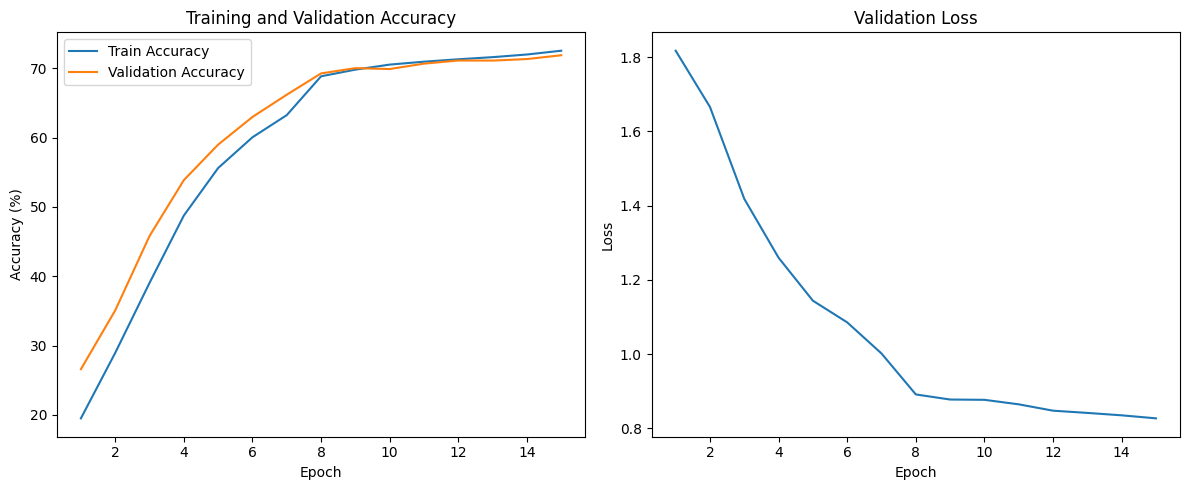

In [16]:
if __name__ == '__main__':
    main()
